# Astro 528, Lab 7, Exercise 2
## GPU Computing II:  Broadcasting, Fusion, Reductions

In this lab exercise, we'll build on programming pattern for harnessing GPUs with a very high-level interface. This assumes that you've successfully gotten GPUs working with Julia from [exercise 1](ex1.ipynb).  Again, students are advised to run the exercises in this lab on ICS-ACI rather than their own system.  

The ICS-ACI Jupyter notebook server and interactive desktop provided by the ICS-ACI portal are now using interactive notes that include a GPU, and students should be able to run all the code there.  However, the GPUs on the interactive nodes are relatively modest GPUs.  You may want to go ahead and submit ex2.pbs, so that it can queue and run on a CyberLAMP GPU node while you work through this notebook.  Then you can review the output to compare the results and performance of the GPUs on the interactive node to that of the CyberLAMP GPU nodes.  For submitting jobs, you'll use the [command line interface](https://ics.psu.edu/computing-services/ics-aci-user-guide/#05-00-basics-aci-resources) to submit the PBS jobs, following a similar syntax as the [lab's 6 README](https://github.com/PsuAstro528/lab6-start/blob/master/README.md).  

## Setting up
First, we'll make sure that `CUDAHOME` is set, activate the project in the current directory and load packages to be used. Here we assume that you've already instantiated this project during exercise 1.

In [2]:
if haskey(ENV,"CUDAHOME")
    println("The CUDAHOME environment variable has been set to: ",ENV["CUDAHOME"])
else
    println("The CUDAHOME environment variable has not been set.  Setting it now...")
    ENV["CUDAHOME"] = "/gpfs/group/ebf11/default/astro528/cuda"
end

The CUDAHOME environment variable has not been set.  Setting it now...


"/gpfs/group/ebf11/default/astro528/cuda"

In [3]:
using Pkg
Pkg.activate(".")

"/storage/home/l/len56/lab7-lenun/Project.toml"

In [4]:
using CUDAnative, CuArrays, GPUArrays

In [5]:
using BenchmarkTools, Statistics

In [6]:
using Plots

In [ ]:
#pyplot()  # in case gr() gives you trouble

## Writing GPU-compatiable functions for broadcasting


You can write high-level julia code for GPUs even if they have more than linear algebra.  Here I'll show a demonstration of solving [Kepler's equation](https://en.wikipedia.org/wiki/Kepler%27s_equation) and computing the radial velocity of a star due to its reflex motion due to a planet following a Keplerian orbit.  Kepler's equation describes the motion in time of a body on a Keplerian orbit.  The "mean anomaly" (M) increases linearly with time, while the "eccentric anomaly" (E) gives the angular position of the body.  Kepler's equation is $$M = E - e \sin(E),$$ where $M$ is the mean anomaly, $E$ is the eccentric anomaly, and $e$ is the orbital eccentricity.  While it is trivial to compute the mean anomaly from the eccentric anomaly, computing the eccentric anomaly at a given time requires an itterative solver, which makes this relatively slow (compared to other parts of orbit calculation) and hence a good candidate for implementing on a GPU.  

To keep the notebook relatively clean, the code for solving Kepler's equation is in [src/kepler_eqn.jl](src/kepler_eqn.jl).  First, let's load that code and its module.

In [7]:
include("src/kepler_eqn.jl")
using .KeplerEqn

Next, we'll create a simple 2-d grid of values of the eccentricity and mean anomaly.  (Feel free to remove the `;`'s to inspect the results.)

In [8]:
num_ecc = 100
num_mean_anom = 200
max_ecc = 0.9
ecc_h = [max_ecc*i/num_ecc for i in 0:(num_ecc-1), j in 0:(num_mean_anom-1) ]
mean_anom_h = [2pi*j/num_mean_anom for i in 0:(num_ecc-1), j in 0:(num_mean_anom-1) ];

As before, we can put these into GPUArrays and perform the calculation on the GPU using Julia's dot-syntax for broadcasting the function to each element of the arrays.

In [9]:
RvPlanetParamT = Float32
ecc_d = CuArray{RvPlanetParamT}(ecc_h)
mean_anom_d = CuArray{RvPlanetParamT}(mean_anom_h)
ecc_anom_d = calc_ecc_anom.(mean_anom_d,ecc_d)

100×200 CuArray{Float32,2}:
  0.0          0.0314159  0.0628319  …  6.15752  6.18894  6.22035  6.25177
  0.0          0.0317012  0.0634021     6.15638  6.18808  6.21978  6.25148
  0.0          0.0319917  0.0639828     6.15522  6.18721  6.2192   6.25119
  0.0          0.0322875  0.0645741     6.15404  6.18633  6.21861  6.2509 
  0.0          0.0325889  0.0651766     6.15284  6.18542  6.21801  6.2506 
  0.0          0.032896   0.0657903  …  6.15162  6.1845   6.2174   6.25029
  0.0          0.0332089  0.0664157     6.15037  6.18357  6.21677  6.24998
  0.0          0.0335278  0.067053      6.1491   6.18261  6.21613  6.24966
  0.0          0.0338529  0.0677027     6.1478   6.18164  6.21548  6.24933
  0.0          0.0341843  0.0683651     6.14648  6.18065  6.21482  6.249  
  0.0          0.0345223  0.0690406  …  6.14514  6.17963  6.21414  6.24866
  0.0          0.0348671  0.0697295     6.14376  6.1786   6.21346  6.24832
  0.0          0.0352188  0.0704323     6.14236  6.17755  6.21275  6.247

Now, we can compare the time to compute the eccentric anomaly at each point in our grid using the CPU and GPU.

In [10]:
@btime ecc_anom_h = calc_ecc_anom.(mean_anom_h,ecc_h) samples=5
CuArrays.@time CuArrays.@sync( ecc_anom_d = calc_ecc_anom.(mean_anom_d,ecc_d) )
CuArrays.@time CuArrays.@sync( ecc_anom_d = calc_ecc_anom.(mean_anom_d,ecc_d) )

  2.857 ms (4 allocations: 156.38 KiB)
  0.555889 seconds (300.03 k CPU allocations: 13.428 MiB) (1 GPU allocation: 78.125 KiB, 0.00% gc time of which 100.00% spent allocating)
  0.643796 seconds (300.03 k CPU allocations: 13.428 MiB, 13.67% gc time) (1 GPU allocation: 78.125 KiB, 0.00% gc time of which 100.00% spent allocating)


100×200 CuArray{Float32,2}:
  0.0          0.0314159  0.0628319  …  6.15752  6.18894  6.22035  6.25177
  0.0          0.0317012  0.0634021     6.15638  6.18808  6.21978  6.25148
  0.0          0.0319917  0.0639828     6.15522  6.18721  6.2192   6.25119
  0.0          0.0322875  0.0645741     6.15404  6.18633  6.21861  6.2509 
  0.0          0.0325889  0.0651766     6.15284  6.18542  6.21801  6.2506 
  0.0          0.032896   0.0657903  …  6.15162  6.1845   6.2174   6.25029
  0.0          0.0332089  0.0664157     6.15037  6.18357  6.21677  6.24998
  0.0          0.0335278  0.067053      6.1491   6.18261  6.21613  6.24966
  0.0          0.0338529  0.0677027     6.1478   6.18164  6.21548  6.24933
  0.0          0.0341843  0.0683651     6.14648  6.18065  6.21482  6.249  
  0.0          0.0345223  0.0690406  …  6.14514  6.17963  6.21414  6.24866
  0.0          0.0348671  0.0697295     6.14376  6.1786   6.21346  6.24832
  0.0          0.0352188  0.0704323     6.14236  6.17755  6.21275  6.247

At this point, the GPU was likely slower than the CPU.  We can further improve the performance by having the GPU write directly to a pre-allocated array, using `.=`.  While this will give us a speed boost, the calculation is performed entirely on the GPU and that comes with some limitations.  In particular, the default `sin` and `sqrt` functions have error handling built in that isn't compatible with the GPU.  The [CUDAnative.jl](https://github.com/JuliaGPU/CUDAnative.jl) package provides access to numerous CUDA-specific function that we can use to work around this problem.  We'll simply  replace calls to `sin(x)` with calls to `CUDAnative.sin(x)` (and similar for `sqrt`).  That's been implemented that in a similar function calc_ecc_anom_gpu, so you can see how to use this technique for your project.

In [11]:
ecc_anom_d = cuzeros(RvPlanetParamT,size(mean_anom_d))
CuArrays.@time CuArrays.@sync( ecc_anom_d .= calc_ecc_anom_gpu.(mean_anom_d,ecc_d) )
CuArrays.@time CuArrays.@sync( ecc_anom_d .= calc_ecc_anom_gpu.(mean_anom_d,ecc_d) )

  6.962803 seconds (10.13 M CPU allocations: 509.437 MiB, 3.86% gc time)
  0.001853 seconds (43 CPU allocations: 2.125 KiB)


100×200 CuArray{Float32,2}:
  0.0          0.0314159  0.0628319  …  6.15752  6.18894  6.22035  6.25177
  0.0          0.0317012  0.0634021     6.15638  6.18808  6.21978  6.25148
  0.0          0.0319917  0.0639828     6.15522  6.18721  6.2192   6.25119
  0.0          0.0322875  0.0645741     6.15404  6.18633  6.21861  6.2509 
  0.0          0.0325889  0.0651766     6.15284  6.18542  6.21801  6.2506 
  0.0          0.032896   0.0657903  …  6.15162  6.1845   6.2174   6.25029
  0.0          0.0332089  0.0664157     6.15037  6.18357  6.21677  6.24998
  0.0          0.0335278  0.067053      6.1491   6.18261  6.21613  6.24966
  0.0          0.0338529  0.0677027     6.1478   6.18164  6.21548  6.24933
  0.0          0.0341843  0.0683651     6.14648  6.18065  6.21482  6.249  
  0.0          0.0345223  0.0690406  …  6.14514  6.17963  6.21414  6.24866
  0.0          0.0348671  0.0697295     6.14376  6.1786   6.21346  6.24832
  0.0          0.0352188  0.0704323     6.14236  6.17755  6.21275  6.247

For fun, we can plot our results for the eccentric anomaly as a function of mean anomaly and eccentricity.

In [12]:
ecc_anom_d .= calc_ecc_anom_gpu.(mean_anom_d,ecc_d)
GPUArrays.synchronize(ecc_anom_d)

In [ ]:
#using Plots   # In case you didn't load Plots earlier
#pyplot()

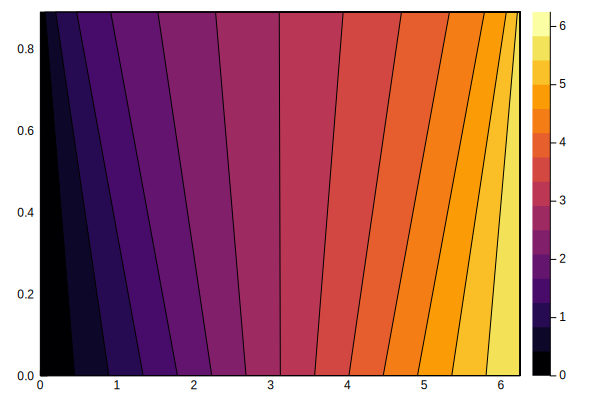

In [13]:
plot(Array(mean_anom_d[1,:]), Array(ecc_d[:,1]), ecc_anom_d, st = :contourf)

## Minimizing launch overhead in GPU calculations: Kernel fusion
Of course, we usually want to perform more complicated calculations than just solving one equation.  For example, we might want to solve Kepler's equation so that we can compute the radial velocity of a star under a given model and compare that to observations.  Think back to the time required to launch a GPU kernel compared to the time to perform it's work.  If we launch lots of small kernels and/or constantly move data back and forth between the GPU and CPU memory systems, we won't be able to realize the computational benefits of a GPU.  Therefore, we'll want to "fuse" multiple operations into one kernel and keep most results on the GPU and only move back the final results we need. The following example demonstrates this programming pattern.

While I put the code for solving Kepler's equation in a separate file, now I'd like you to pay closer attention to syntax of writing functions for a GPU, so I've left the code for computing the radial velocity due to a planet on a Keplerian orbit in the notebook.

In [14]:
"""   calc_rv_one_planet(P,K,h,k,M0, time) 
Calculate radial velocity of star due to planet following Keplerian orbit at specified time.
Inputs:
- Period
- RV amplitude
- h = e sin(omega)
- k = e cos(omega)
- mean anomaly at time=0
- time
This differs from usual expressions so as to be differntiable, even at zero eccentricity.  
Based on "An analytical solution for Kepler's problem"
Pál, András, Monthly Notices of the Royal Astronomical Society, 396, 3, 1737-1742.  2009MNRAS.396.1737P
"""
function calc_rv_one_planet(P::T1,K::T1,h::T1,k::T1,M0::T1, time::T2)  where {T1<:Number, T2<:Number}
  ecc = sqrt(h*h+k*k)
  w = atan(k,h)
  n = T1(2pi)/P
  M = time*n-M0
  E = calc_ecc_anom(M,ecc)
  lambda = w+M
  lpesE = lambda+ecc*sin(E)  
  c = cos(lpesE)
  s = sin(lpesE)
  @assert(zero(ecc)<=ecc<one(ecc))
  j = sqrt((one(T1)-ecc)*(one(T1)+ecc))
  p, q = (ecc == zero(T1)) ? (zero(T1), zero(T1)) : (ecc*sin(E), ecc*cos(E))
  a = K/(n/sqrt((one(T1)-ecc)*(one(T1)+ecc)))
  zdot = a*n/(one(T1)-q)*( cos(lambda+p)-k*q/(one(T1)+j) )
end

function calc_rv_one_planet_gpu(P::T1,K::T1,h::T1,k::T1,M0::T1, time::T2) where {T1<:Float32, T2<:Number}
  ecc = CUDAnative.sqrt(h*h+k*k)
  n = T1(2pi)/P
  M = mod(time*n-M0,T2(2pi))  # Allow for modulus operation to be in Float64 if times are
  M = T1(M)                   # Once in small range convert to Float32 for speed
  E = calc_ecc_anom_gpu(M,ecc)
  w = CUDAnative.atan2(k,h)
  lambda = w+M   
  lpesE = lambda+ecc*CUDAnative.sin(E)
  c = CUDAnative.cos(lpesE)
  s = CUDAnative.sin(lpesE)
  @assert(zero(ecc)<=ecc<one(ecc))
  j = CUDAnative.sqrt((one(T2)-ecc)*(one(T2)+ecc))
  p, q = (ecc == zero(T2)) ? (zero(T2), zero(T2)) : (ecc*CUDAnative.sin(E), ecc*CUDAnative.cos(E))
  a = K*P/T1(2pi)*CUDAnative.sqrt((one(T2)-ecc)*(one(T2)+ecc))
  zdot = a*n/(one(T2)-q)*( CUDAnative.cos(lambda+p)-k*q/(one(T2)+j) )
end

calc_rv_one_planet_gpu (generic function with 1 method)

First, notice that each function takes a list of scalars.  We'll use Julia's dot broadcasting to operate on arrays.  Previously, we discussed the danger of having a function take a long list of arguments.  Consider the functions above a low-level interface that a GPU programmer would write and test once, but users wouldn't use.  Then we can reduce the risk of problems and make the code more convenient by defining a composite structure to contain the planet's RV parameters, along with helper functions that unpack the composite type and call the low-level function.

In [15]:
struct RvPlanetParam{T<:Number}
   P::T
   K::T
   h::T
   k::T
   M0::T
end

function calc_rv_one_planet(theta::RvPlanetParam{T1}, time::T2) where {T1<:Number,T2<:Number}
  P,K,h,k,M0 = theta.P, theta.K, theta.h, theta.k, theta.M0
  calc_rv_one_planet(P,K,h,k,M0, time)
end

function calc_rv_one_planet_gpu(theta::RvPlanetParam{T1}, time::T2) where {T1<:Number,T2<:Number}
  P,K,h,k,M0 = theta.P, theta.K, theta.h, theta.k, theta.M0
  calc_rv_one_planet_gpu(P,K,h,k,M0, time)
end

function calc_rv_one_planet_gpu_fast(theta::RvPlanetParam{T1}, time::T2) where {T1<:Number,T2<:Number}
  P,K,h,k,M0 = theta.P, theta.K, theta.h, theta.k, theta.M0
  calc_rv_one_planet_gpu_fast(P,K,h,k,M0, time)
end

calc_rv_one_planet_gpu_fast (generic function with 1 method)

Now, we could create a nice interface for setting and accessing the data in `RvPlanetParms`.  At the same time, this pattern allows both the CPU and the GPU to store and access to the data in a very efficient way.  In particular, Julia's dot broadcasting allows us to pass separate arrays for each parameter.  For example,

In [16]:
RvPlanetParam.([4.0,5.0],[10.0,9.0],[0.05,0.05],[-0.1,0.1],[0.1*pi,0.2*pi])

2-element Array{RvPlanetParam{Float64},1}:
 RvPlanetParam{Float64}(4.0, 10.0, 0.05, -0.1, 0.3141592653589793)
 RvPlanetParam{Float64}(5.0, 9.0, 0.05, 0.1, 0.6283185307179586)  

Now, let's create a set of simulated observations times over ~8 months.  This time, instead of generating the data on the CPU and moving it to the GPU, we'll generate the random values on the GPU (using the `CuArrays` interface to the [CURAND](https://docs.nvidia.com/cuda/curand/index.html) library from the CUDA toolkit), perform arithmetic on the GPU, and then sort the resulting times, all leaving the data on the GPU.

In [17]:
import CuArrays: CURAND.curand, CURAND.curandn

In [18]:
num_obs = 200
min_obs_time = 0.0f0
max_obs_time = 240.0f0
times_d = min_obs_time .+ (max_obs_time-min_obs_time) .* curand(Float64,num_obs) 
sort!(times_d)

200-element CuArray{Float64,1}:
   0.6269036702717967
   0.7337888032924367
   3.046128967678974 
   4.947166795588642 
   6.800993592471989 
   9.869932393857216 
   9.949407090442278 
  10.281552897056518 
  10.889240277267117 
  12.475355875419577 
  12.722669692033254 
  13.192219770726282 
  13.534013126603138 
   ⋮                 
 223.55042572479945  
 224.86289066753318  
 225.18715516216884  
 225.29230559820962  
 228.6171085731441   
 228.66145134909718  
 229.21998926568074  
 234.26894678414416  
 234.5695550860133   
 234.98705284677507  
 237.587973994354    
 237.88772456711797  

And definte the true parameters for a simulated data set.

In [19]:
P_true = 4.0
K_true = 10.0
h_true = 0.05
k_true = 0.10
M0_true = pi/4
sigma_obs = 1.0f0
param_h = [RvPlanetParam{RvPlanetParamT}(P_true,K_true,h_true,k_true,M0_true)]
param_d = cu(param_h)

1-element CuArray{RvPlanetParam{Float32},1}:
 RvPlanetParam{Float32}(4.0f0, 10.0f0, 0.05f0, 0.1f0, 0.7853982f0)

We can compute the radial velocities under the true model, either on the GPU.

In [20]:
using CUDAnative

In [21]:
rvs_true_d = cuzeros(Float32,num_obs)
rvs_true_fast_d = cuzeros(Float32,num_obs)
#@code_warntype  calc_rv_one_planet_gpu.(param_d,times_d)
rvs_true_d = calc_rv_one_planet_gpu.(param_d,times_d)
#rvs_true_fast_d = calc_rv_one_planet_gpu_fast.(param_d,times_d)
rvs_obs_d = rvs_true_d .+ sigma_obs .* curandn(RvPlanetParamT,num_obs)

200-element CuArray{Float64,1}:
   2.9173748321841404
   0.7550616523335052
   1.9731450247096247
  -2.2370320733278235
  -1.088626253490176 
  -9.329920751273042 
  -8.472811652614824 
  -6.459346326507725 
   0.5169854927642034
   4.620489082139019 
   0.7742351258897432
  -7.02644149698503  
 -10.357728058025874 
   ⋮                 
  10.80134505221426  
  -1.2949730295365667
  -7.0955439686245585
  -8.299400916199065 
   2.7711662237924655
   1.0281111329350525
  -4.911651357139172 
  -6.507951350349715 
  -2.542808917775492 
   1.0401252702714525
 -10.538200952360878 
  -8.714803792597356 

Note that we passed an array of RvPlanetParam, so we're using good programming practices, and our helper function allows Julia to convert that into call the low-level function for the GPU.  We can bring the results back to the CPU using `Array`.

In [22]:
rvs_obs_h = Array(rvs_obs_d)

200-element Array{Float64,1}:
   2.9173748321841404
   0.7550616523335052
   1.9731450247096247
  -2.2370320733278235
  -1.088626253490176 
  -9.329920751273042 
  -8.472811652614824 
  -6.459346326507725 
   0.5169854927642034
   4.620489082139019 
   0.7742351258897432
  -7.02644149698503  
 -10.357728058025874 
   ⋮                 
  10.80134505221426  
  -1.2949730295365667
  -7.0955439686245585
  -8.299400916199065 
   2.7711662237924655
   1.0281111329350525
  -4.911651357139172 
  -6.507951350349715 
  -2.542808917775492 
   1.0401252702714525
 -10.538200952360878 
  -8.714803792597356 

Often, we need to explore a large parameter space to search for a good model.  For sake of an example, we'll use a simple Monte Carlo search.  Of course, it is usually wise to use a more efficient algorithm.

In [23]:
num_param = 10000
Plist_d = P_true .* ( 1.0 .+ 0.01 .* (curand(RvPlanetParamT,num_param).-0.5) )
Klist_d = K_true .* ( 1.0 .+ 0.1  .* (curand(RvPlanetParamT,num_param).-0.5) )
hlist_d = h_true .+ 0.1 .* (curand(RvPlanetParamT,num_param).-0.5)
klist_d = k_true .+ 0.1 .* (curand(RvPlanetParamT,num_param).-0.5)
M0list_d = M0_true .+ 2pi .* 0.1 .* (curand(RvPlanetParamT,num_param).-0.5)
CuArrays.@time CuArrays.@sync ( params_d = RvPlanetParam{RvPlanetParamT}.(Plist_d, Klist_d, hlist_d, klist_d, M0list_d); )

  0.568979 seconds (1.26 M CPU allocations: 62.470 MiB, 5.09% gc time) (1 GPU allocation: 195.313 KiB, 0.01% gc time of which 100.00% spent allocating)


10000-element CuArray{RvPlanetParam{Float32},1}:
 RvPlanetParam{Float32}(4.0190716f0, 10.300791f0, 0.089038834f0, 0.11891791f0, 1.0572947f0) 
 RvPlanetParam{Float32}(3.9831228f0, 9.816292f0, 0.018108852f0, 0.13788892f0, 1.0868404f0)  
 RvPlanetParam{Float32}(3.9997685f0, 10.433599f0, 0.011856169f0, 0.078767054f0, 0.9501965f0)
 RvPlanetParam{Float32}(3.9942439f0, 10.110601f0, 0.025374928f0, 0.12533282f0, 0.83741796f0)
 RvPlanetParam{Float32}(4.0027003f0, 10.064819f0, 0.041037716f0, 0.12010078f0, 0.87808627f0)
 RvPlanetParam{Float32}(3.9881713f0, 10.238876f0, 0.08241079f0, 0.14281845f0, 0.52208227f0) 
 RvPlanetParam{Float32}(4.0124393f0, 9.7114725f0, 0.06515516f0, 0.062550776f0, 0.7469543f0) 
 RvPlanetParam{Float32}(4.012244f0, 9.936222f0, 0.06171138f0, 0.06318895f0, 0.60845464f0)   
 RvPlanetParam{Float32}(4.013903f0, 9.63022f0, 0.0707295f0, 0.057760596f0, 0.9571171f0)     
 RvPlanetParam{Float32}(4.012328f0, 9.560966f0, 0.088363215f0, 0.11095138f0, 0.5906891f0)   
 RvPlanetParam{Float3

Now we'll want to evaluate the Planet's velocity at each time and for each set of model parameters.  We can acheive that using Julia's [`repeat`](https://docs.julialang.org/en/v1/base/arrays/#Base.repeat) and [`reshape`](https://docs.julialang.org/en/v1/base/arrays/#Base.reshape) functions to minimize unnecessary copying of the data, just as we would do the CPU.  It may be useful to look at the size and/or contents of the new CuArrays being being created, to help understand the upcoming function call.  

(For some reason the Weave script gave an error when I left out the semi-colons.  If you remove the semi-colons, then I'd suggest restoring the semi-colons after each of the next two cells before submitting this notebook as a batch job.)

In [24]:
CuArrays.@time expanded_times_d = reshape(repeat(times_d,num_param),num_obs,num_param);

  0.355498 seconds (754.45 k CPU allocations: 39.049 MiB, 5.26% gc time) (1 GPU allocation: 15.259 MiB, 0.11% gc time of which 100.00% spent allocating)


In [25]:
CuArrays.@time expanded_params_d = reshape(params_d,1,num_param);

  0.016732 seconds (27.37 k CPU allocations: 1.414 MiB)


How much GPU memory was required for each of the above operations.  How does that compare to creating new arrays of `num_obs`x`num_param`?
    
INSERT RESPONSE **GPU memory was 1 GPU allocation: 15.259 MiB.**

Now, let's compute the radial velocity at each time for each set of parameters.  We'll time the results and compare to the time on the CPU.  Remember, that the first call to a function with a given set of parameter types results in an expensive compile operation on either the CPU or GPU.  So we'll run each twice.

In [25]:
rvs_d = cuzeros(RvPlanetParamT,num_param,num_obs)
CuArrays.@time CuArrays.@sync( rvs_d .=  calc_rv_one_planet_gpu.(reshape(params_d,num_param,1), reshape(repeat(times_d,num_param),num_obs,num_param)' ) )
CuArrays.@time CuArrays.@sync( rvs_d .=  calc_rv_one_planet_gpu.(reshape(params_d,num_param,1), reshape(repeat(times_d,num_param),num_obs,num_param)' ) )

  1.738143 seconds (2.56 M CPU allocations: 124.453 MiB, 4.64% gc time) (1 GPU allocation: 15.259 MiB, 0.02% gc time of which 100.00% spent allocating)
  0.145426 seconds (102 CPU allocations: 4.094 KiB) (1 GPU allocation: 15.259 MiB)


10000×200 CuArray{Float32,2}:
  7.89687    6.01056   -1.2733    …  -9.35202    10.0452       5.45567
  2.62017    0.438784   3.27481       9.94966    -2.15363      1.36849
  1.22531   -0.828687   4.6783        4.0788    -10.3077      -9.24717
  0.245518  -1.92752    4.66597       7.65236    -7.97459     -5.1707 
  2.27095    0.103851   3.19317       0.486964   -9.25972     -9.4919 
 -0.455604  -2.63567    4.28661   …  10.6614     -4.62682     -1.3864 
  5.49231    3.73408    0.107903     -7.98796     1.648       -3.32706
  3.81906    1.92722    1.65295      -7.34412    -0.415344    -5.11397
  7.96541    6.55626   -2.35485      -8.89972     6.05867      1.08721
  2.28416    0.242482   2.21628      -6.03422    -2.04659     -6.24004
 -1.82948   -3.97103    5.50655   …  -5.45906    -2.76961     -7.70391
  5.04922    2.92368    0.604384      3.98808    -8.83966     -7.57592
  6.76425    4.81138   -0.338966     -1.03452    -8.38998     -9.14854
  ⋮                               ⋱            

In [26]:
params_h = Array(params_d)
times_h = Array(times_d)
@time rvs_h = calc_rv_one_planet.(reshape(params_h,num_param,1), reshape(repeat(times_h,num_param),num_obs,num_param)' )
@time rvs_h = calc_rv_one_planet.(reshape(params_h,num_param,1), reshape(repeat(times_h,num_param),num_obs,num_param)' )

  1.289365 seconds (8.72 M allocations: 250.479 MiB, 13.26% gc time)
  0.983534 seconds (8.00 M allocations: 213.624 MiB, 15.55% gc time)


10000×200 Array{Float64,2}:
  7.89688    6.01056   -1.2733    …  -9.35202    10.0452       5.45567
  2.62017    0.438785   3.27481       9.94966    -2.15363      1.36849
  1.22531   -0.828687   4.6783        4.0788    -10.3077      -9.24717
  0.245518  -1.92752    4.66597       7.65236    -7.97459     -5.17071
  2.27095    0.103851   3.19317       0.486966   -9.25972     -9.4919 
 -0.455605  -2.63567    4.28661   …  10.6614     -4.62682     -1.3864 
  5.49231    3.73408    0.107901     -7.98795     1.648       -3.32706
  3.81906    1.92722    1.65294      -7.34412    -0.415344    -5.11397
  7.96541    6.55626   -2.35485      -8.89972     6.05867      1.08721
  2.28416    0.242483   2.21628      -6.03422    -2.04659     -6.24004
 -1.82948   -3.97103    5.50655   …  -5.45906    -2.76961     -7.70391
  5.04922    2.92368    0.604385      3.98808    -8.83966     -7.57592
  6.76425    4.81138   -0.338966     -1.03452    -8.38998     -9.14854
  ⋮                               ⋱              

How does the GPU and CPU performance compare for this calculation?
    
INSERT RESPONSE **The runtimes for the first calculation were 1.738143 seconds and 0.145426 seconds. This one ran in 1.289365 seconds and 0.983534 seconds.**

How large are the differences between the calculations on the CPU and GPU?  
Once you've run this notebook on a dedicated CyberLAMP GPU node, come back and expand on your comparison, noting any difference between the interactive and CyberLAMP nodes.

INSERT RESPONSES

In [27]:
maximum(abs.(Array(rvs_d).-rvs_h))

9.313611468275695e-6

## Minimizing communications overhead in GPU calculations: Reductions
So far we've compute the velocity at each time.  Often we'd be most interested in the quality of the fit summing the differences between the model and data at each time.  We can do that, keeping all the data on the GPU using `sum`.  (GPUArrays also provided `prod` for prodcut reductions and a more generic `reduce`.)

In [28]:
chisq_d = vec(sum(((rvs_d.-rvs_obs_d')./sigma_obs).^2,dims=2) )

10000-element CuArray{Float64,1}:
 15511.999693438667  
  8044.262941332158  
   564.3995044262094 
  3166.5979222675173 
   262.7080906221571 
  7145.678175873751  
  7854.240800592809  
  5667.860503802437  
 13108.754029870186  
  4243.998703701693  
  3169.852499867521  
   547.8529527812798 
  1479.0797177530212 
     ⋮               
  1401.8017937337738 
  1570.5705468807348 
   733.3101370028488 
  4168.724756082501  
 13432.787821788914  
  2924.583805857019  
  7395.924097321731  
 12564.87090047101   
  5894.020963275168  
   491.99024853851887
 14945.384283004169  
  1522.203911171946  

By performing the reduction on the GPU, we get faster calculation of $\chi^2$, but more importantly, we reduce the amount of data that would need to be sent from the GPU to the CPU's memory system.

In [29]:
CuArrays.@time CuArrays.@sync( chi_sq_d = sum(((rvs_d.-rvs_obs_d')./sigma_obs).^2,dims=2) )

  0.005471 seconds (205 CPU allocations: 7.641 KiB) (2 GPU allocations: 15.335 MiB, 10.16% gc time of which 100.00% spent allocating)


10000×1 CuArray{Float64,2}:
 15511.999693438667  
  8044.262941332158  
   564.3995044262094 
  3166.5979222675173 
   262.7080906221571 
  7145.678175873751  
  7854.240800592809  
  5667.860503802437  
 13108.754029870186  
  4243.998703701693  
  3169.852499867521  
   547.8529527812798 
  1479.0797177530212 
     ⋮               
  1401.8017937337738 
  1570.5705468807348 
   733.3101370028488 
  4168.724756082501  
 13432.787821788914  
  2924.583805857019  
  7395.924097321731  
 12564.87090047101   
  5894.020963275168  
   491.99024853851887
 14945.384283004169  
  1522.203911171946  

In [30]:
CuArrays.@time CuArrays.@sync( rvs_h = Array(rvs_d) )

  0.003179 seconds (9 CPU allocations: 7.630 MiB)


10000×200 Array{Float32,2}:
  7.89687    6.01056   -1.2733    …  -9.35202    10.0452       5.45567
  2.62017    0.438784   3.27481       9.94966    -2.15363      1.36849
  1.22531   -0.828687   4.6783        4.0788    -10.3077      -9.24717
  0.245518  -1.92752    4.66597       7.65236    -7.97459     -5.1707 
  2.27095    0.103851   3.19317       0.486964   -9.25972     -9.4919 
 -0.455604  -2.63567    4.28661   …  10.6614     -4.62682     -1.3864 
  5.49231    3.73408    0.107903     -7.98796     1.648       -3.32706
  3.81906    1.92722    1.65295      -7.34412    -0.415344    -5.11397
  7.96541    6.55626   -2.35485      -8.89972     6.05867      1.08721
  2.28416    0.242482   2.21628      -6.03422    -2.04659     -6.24004
 -1.82948   -3.97103    5.50655   …  -5.45906    -2.76961     -7.70391
  5.04922    2.92368    0.604384      3.98808    -8.83966     -7.57592
  6.76425    4.81138   -0.338966     -1.03452    -8.38998     -9.14854
  ⋮                               ⋱              

In [31]:
CuArrays.@time CuArrays.@sync( chi_sq_h = Array(chi_sq_d) )

  0.003073 seconds (153 CPU allocations: 90.125 KiB)


10000×1 Array{Float64,2}:
 15511.999693438667  
  8044.262941332158  
   564.3995044262094 
  3166.5979222675173 
   262.7080906221571 
  7145.678175873751  
  7854.240800592809  
  5667.860503802437  
 13108.754029870186  
  4243.998703701693  
  3169.852499867521  
   547.8529527812798 
  1479.0797177530212 
     ⋮               
  1401.8017937337738 
  1570.5705468807348 
   733.3101370028488 
  4168.724756082501  
 13432.787821788914  
  2924.583805857019  
  7395.924097321731  
 12564.87090047101   
  5894.020963275168  
   491.99024853851887
 14945.384283004169  
  1522.203911171946  

How much longer does it take to send the array of all velocities back to the host, as compared to sending back only the $chi^2$ values?

INSERT RESPONSE **The longer method took 0.003073; the faster one, 0.003179 seconds. The difference is about 0.1 ms.**

In some cases, we may not even need to send all of the results back to the CPU.  For example, maybe we just want to find the best fitting model

In [32]:
CuArrays.@time (chisq_good, idx_good) = findmin(chisq_d)
CuArrays.@time good_param = params_d[idx_good]

  0.119729 seconds (109.62 k CPU allocations: 4.893 MiB)
  0.009357 seconds (253 CPU allocations: 14.688 KiB)


RvPlanetParam{Float32}(4.000097f0, 10.148319f0, 0.051229607f0, 0.09706468f0, 0.77568555f0)

How does the time required to send back just the parameters from the best-fit model (so far) compare to the time required to send back all of the values of $\chi^2$? 

RESPONSE **The runtimes were 0.119729 seconds and 0.009357 seconds. The difference is about 0.1 seconds.**

Just for fun, we can compare those values to the true parameters that we've kept on the host.

In [1]:
println("True param: ",param_h[1])

UndefVarError: UndefVarError: param_h not defined

In [34]:
println("Differences: ", map(fn->getfield(good_param,fn)-getfield(param_h[1],fn), fieldnames(typeof(good_param)) ) )
println("ChiSq: ", chisq_good)

Differences: (9.679794f-5, 0.14831924f0, 0.0012296066f0, -0.0029353201f0, -0.0097126365f0)
ChiSq: 175.0938969823059


And graphically compare the predictions of the true model and the one we found, first in time and then in orbital phase.

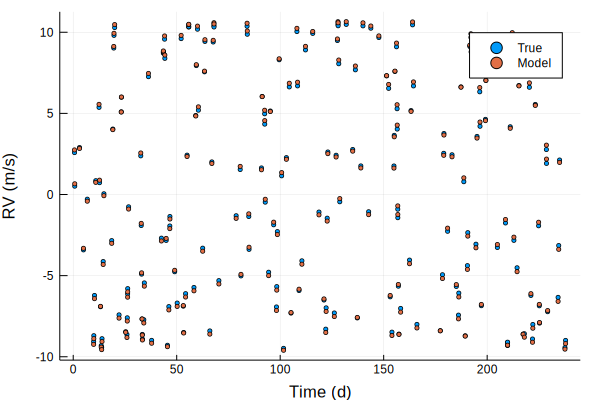

In [35]:
scatter(times_h,calc_rv_one_planet.(param_h,times_h), markersize=2, xlabel="Time (d)", ylabel="RV (m/s)", label="True")
scatter!(times_h,calc_rv_one_planet.([good_param],times_h), label="Model", markersize=2)

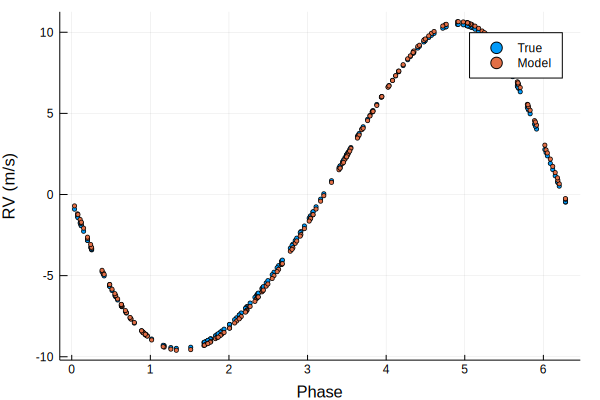

In [36]:
scatter(2pi/param_h[1].P.*mod.(times_h.-param_h[1].M0,param_h[1].P),calc_rv_one_planet.(param_h,times_h), markersize=2, xlabel="Phase", ylabel="RV (m/s)", label="True")
scatter!(2pi/param_h[1].P.*mod.(times_h.-param_h[1].M0,param_h[1].P),calc_rv_one_planet.([good_param],times_h), label="Model", markersize=2)

## Implications for your Class Project
Now that you've seen a tour of how to perform basic GPU computing, do you think that GPU computing would be likely to provide a significant performance benefit for the calculations in your class project?  Why or why not?
        
INSERT RESPONSE **I think I could use GPU computing in my project. I could compare performance of GPU vs CPU.**